In [1]:
import sys
# Change to wherever you've copied the repo.
sys.path.insert(1, '/home/richard/nfmc_jax/')
import nfmc_jax
import arviz as az
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
import scipy
from sklearn.neighbors import KernelDensity
import jax
import jax.numpy as jnp
from jax.scipy.special import logsumexp
from jax.scipy.stats import multivariate_normal as mvn
from scipy.stats import multivariate_normal as n_mvn
import chaospy
import corner
import torch
import warnings
import pickle

import getdist
from getdist import plots, MCSamples

seed=1234
np.random.seed(seed)
key = jax.random.PRNGKey(seed)

# Logistic regression with the German credit dataset ...

In [2]:
data = np.genfromtxt("./fiducial_samples/german.data-numeric")
x = data[:, :-1]
y = (data[:, -1] - 1).astype(np.int32)

x_min = np.min(x, 0, keepdims=True)
x_max = np.max(x, 0, keepdims=True)

x /= (x_max - x_min)
x = 2.0 * x - 1.0

x = np.concatenate([x, np.ones([x.shape[0], 1])], -1)

In [3]:
n = x.shape[0]
d = x.shape[1]

def log_like(params, data=y, covariates=x):
    
    tau = params[0]
    lam = params[1:d+1]
    beta = params[d+1:]
    
    f = jnp.dot(covariates, tau * beta * lam)
    
    return jnp.sum(jax.scipy.stats.bernoulli.logpmf(k=data, p=jax.scipy.special.expit(f)))

def log_prior(params):
    
    tau = params[0]
    lam = params[1:d+1]
    beta = params[d+1:]
    logp_tau = tau + jax.scipy.stats.gamma.logpdf(x=tau, a=0.5, scale=1.0/0.5)
    logp_lam = jnp.sum(lam + jax.scipy.stats.gamma.logpdf(x=lam, a=0.5, scale=1.0/0.5))
    logp_beta = jax.scipy.stats.multivariate_normal.logpdf(beta, mean=jnp.zeros(d), cov=jnp.eye(d))
    
    return logp_tau + logp_lam + logp_beta

def prior_rvs(key, N):
    
    tau = 0.5 * jax.random.gamma(key, a=0.5, shape=(N,))
    lam = 0.5 * jax.random.gamma(key, a=0.5, shape=(N, d))
    beta = jax.random.normal(key, shape=(N, d))
    
    return jnp.concatenate([tau.reshape(N, 1), lam, beta], axis=1)

log_like_grad = jax.grad(log_like)
log_prior_grad = jax.grad(log_prior)

prior_init = prior_rvs(jax.random.PRNGKey(0), 20)

#np.savetxt('./german_credit_prior_samples.txt')

lower = [0 for i in range(d + 1)]
for i in range(d):
    lower.append(None)
upper = [None for i in range(2 * d + 1)]

print(n)
print(d)

1000
25


In [4]:
print(jnp.shape(prior_init))

llk = jax.vmap(lambda x: log_like(x))(prior_init)
lpr = jax.vmap(lambda x: log_prior(x))(prior_init)
print(jnp.shape(llk))
print(jnp.shape(lpr))

(20, 51)
(20,)
(20,)


In [5]:
truth_df = pd.read_csv('./fiducial_samples/german_credit_nuts_samples.csv', index_col=0)
truth_x = np.empty((4000, 51))

print(truth_df.columns)

truth_x[:, 0] = truth_df["('posterior', 'tau')"]
for i in range(d):
    truth_x[:, i + 1] = truth_df["('posterior', 'lam[{0}]', {1})".format(i, i)]
for i in range(d):
    truth_x[:, i + 26] = truth_df["('posterior', 'beta[{0}]', {1})".format(i, i)]
    
np.savetxt('./fiducial_samples/german_credit_nuts_samples.txt', truth_x)

tau_ref = truth_df["('posterior', 'tau')"]
print(tau_ref)

print(truth_x[:, 50])

Index(['chain', 'draw', '('posterior', 'beta[0]', 0)',
       '('posterior', 'beta[10]', 10)', '('posterior', 'beta[11]', 11)',
       '('posterior', 'beta[12]', 12)', '('posterior', 'beta[13]', 13)',
       '('posterior', 'beta[14]', 14)', '('posterior', 'beta[15]', 15)',
       '('posterior', 'beta[16]', 16)',
       ...
       '('sample_stats', 'perf_counter_diff')', '('sample_stats', 'energy')',
       '('sample_stats', 'n_steps')', '('sample_stats', 'perf_counter_start')',
       '('sample_stats', 'step_size_bar')',
       '('sample_stats', 'process_time_diff')',
       '('sample_stats', 'step_size')', '('sample_stats', 'diverging')',
       '('sample_stats', 'max_energy_error')', '('sample_stats', 'lp')'],
      dtype='object', length=1066)
0       0.799909
1       0.628742
2       0.720149
3       0.541626
4       0.878695
          ...   
3995    0.414095
3996    0.601444
3997    0.682545
3998    0.304233
3999    0.282785
Name: ('posterior', 'tau'), Length: 4000, dtype: float64

<AxesSubplot:ylabel='Density'>

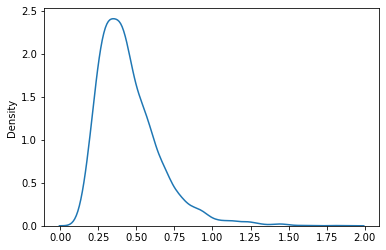

In [6]:
sns.kdeplot(truth_x[:, 0])

In [7]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed
init_logq = None

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0.98, 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = 60
trainable_qw = False # Just leave this for now.
sgd_steps = 0
gamma = 0
knots_trainable = 60
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = False
Whiten_with_weights = False
iteration = 50
NERCOME = False
t_ess = 0.5
MSWD_max_iter = None
Whiten_reg = 0.01

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.0
frac_validate = 0.2
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 0.5
reg2 = 0.5
latent_mcmc = 'LIMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True
fixed_beta_updates = 'LIMH'
nf_iter = 25
slice_iterations = 10

dla_step_size = 1.0
num_extra_dla_samples = 164
grad_norm_thresh = 0.3
max_dla_line_steps = 5
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.2
accelerate_dla = False
grad_free_dla = False
dla_beta_thresh = 0.3
latent_dla = True
rel_fish_tol = 1e-2
abs_fish_tol = 1e-3
maxknot = True

max_dla_iter = 150

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 200

mala_step_size = 1.0
num_mala = 0
tune_mala = 4

cull_lowp_tol = 1e-2

Now we can run our 10d Gaussian example.

In [8]:
trace = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_prior,
                             prior_rvs_func=prior_rvs,
                             init_samples=prior_init,
                             log_like_args=log_like_args,
                             log_prior_args=log_prior_args,
                             init_logq=None,
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             frac_validate=frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla,
                             dla_beta_thresh=dla_beta_thresh,
                             latent_dla=latent_dla,
                             rel_fish_tol=rel_fish_tol,
                             abs_fish_tol=abs_fish_tol,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             cull_lowp_tol=cull_lowp_tol,
                             maxknot=maxknot,
                             MSWD_max_iter=MSWD_max_iter,
                             Whiten_reg=Whiten_reg)

Inference mode is DLA. Maximum beta is set to 1.
bounds_sinf = [[0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]
prop_likelihood_logp = [-990.91785 -817.3309  -952.46423 -706.5893  -922.35187 -767.1121
 -997.9     -584.046   -842.8877  -823.199   -609.14246 -653.30396
 -688.84955 -779.7335  -792.318   -856.1808  -692.06195 -798.8527
 -640.26385 -705.2555 ]
prop_prior_logp = [      -inf       -inf       -inf   

nan_inf = [0 1 2 4 6]
prop_likelihood_logp = [ -693.1458   -663.65784  -679.4295  -1302.3169   -692.7802 ]
prop_prior_logp = [-inf -inf -inf -inf -inf]
prop_logp = [-inf -inf -inf -inf -inf]
increased_logL = []
decreased_logL = [0 1 2 3 4]
nan_inf = [0 1 2 3 4]
prop_likelihood_logp = [ -693.15594  -663.71545  -679.4677  -1302.5719   -692.784  ]
prop_prior_logp = [-19.052414       -inf       -inf       -inf       -inf]
prop_logp = [-712.2084      -inf      -inf      -inf      -inf]
increased_logL = [0]
decreased_logL = [1 2 3 4]
nan_inf = [1 2 3 4]
prop_likelihood_logp = [ -663.7444  -679.4867 -1302.6996  -692.7859]
prop_prior_logp = [      -inf       -inf -17.031317 -14.989872]
prop_logp = [       -inf        -inf -1319.731    -707.77576]
increased_logL = [2 3]
decreased_logL = [0 1]
nan_inf = [0 1]
prop_likelihood_logp = [-663.75885 -679.4962 ]
prop_prior_logp = [      -inf -12.863464]
prop_logp = [     -inf -692.3597]
increased_logL = [1]
decreased_logL = [0]
nan_inf = [0]
prop_likel

/home/richard/nfmc_jax/nfmc_jax/sinf/SINF.py:547: UserWarning: torch.qr is deprecated in favor of torch.linalg.qr and will be removed in a future PyTorch release.
The boolean parameter 'some' has been replaced with a string parameter 'mode'.
Q, R = torch.qr(A, some)
should be replaced with
Q, R = torch.linalg.qr(A, 'reduced' if some else 'complete') (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448222085/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1940.)
  Q, R = torch.qr(ATi)


Current logZ estimate = -572.7022094726562
Acceptance rate for MH adjustment: 0.3
Time for DLA MH adjustment = 1.016336470000006
<norm> = 67.77410125732422
max(norm) = 271.4820861816406
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.4
Time for latent space DLA = 4.895044929000001
Current logZ estimate = -563.3145141601562
Burnin stage 1, Fisher Divergence: 18258.41015625
Burnin stage 1, abs(norm(dlogq)/norm(dlogp)) = 1.3851743936538696
Gradient norms are comparable - ending burnin ...
Stage 1, Sample Mean: 0.15995249152183533
Stage 1, Sample Variance: 0.8080741763114929
Current logZ estimate = -543.5466918945312
DLA stage 1, Latent Fisher Divergence: 315826.21875
Primary DLA stage 1, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.035091981291770935
Acceptance rate for MH adjustment: 0.4076086956521739
Time for DLA MH adjustment = 4.253834131000005
<norm> = 158.6358642578125
max(norm) = 1880.0523681640625
Number of particles that 

Time for latent space DLA = 5.753669527
Stage 14, Sample Mean: 0.1867281198501587
Stage 14, Sample Variance: 0.8388761281967163
Current logZ estimate = -476.0738830566406
DLA stage 14, Latent Fisher Divergence: 2151.512451171875
Primary DLA stage 14, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.02749740518629551
Acceptance rate for MH adjustment: 0.016304347826086956
Time for DLA MH adjustment = 1.0624592559999826
<norm> = 44.573974609375
max(norm) = 150.2303924560547
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.048913043478261
Time for latent space DLA = 6.758659485999999
Stage 15, Sample Mean: 0.18966710567474365
Stage 15, Sample Variance: 0.8453829884529114
Current logZ estimate = -473.778564453125
DLA stage 15, Latent Fisher Divergence: 2120.18115234375
Primary DLA stage 15, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.026095252484083176
Acceptance rate for MH adjustment: 0.021739130434782608
Time for DLA MH adjustment = 1.02246510099

<norm> = 37.79685592651367
max(norm) = 133.04156494140625
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.016304347826087
Time for latent space DLA = 3.329941223999981
Stage 28, Sample Mean: 0.20957033336162567
Stage 28, Sample Variance: 0.861793041229248
Current logZ estimate = -461.85736083984375
DLA stage 28, Latent Fisher Divergence: 1608.64453125
Primary DLA stage 28, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.04307972267270088
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.8945279990000472
<norm> = 37.037620544433594
max(norm) = 136.0353240966797
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0434782608695652
Time for latent space DLA = 3.3587312860000225
Stage 29, Sample Mean: 0.210906520485878
Stage 29, Sample Variance: 0.8636677265167236
Current logZ estimate = -462.7331237792969
DLA stage 29, Latent Fisher Divergence: 1659.

Time for DLA MH adjustment = 1.0552825899999903
<norm> = 34.219261169433594
max(norm) = 121.28917694091797
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.016304347826087
Time for latent space DLA = 3.785692928000003
Stage 42, Sample Mean: 0.2287687361240387
Stage 42, Sample Variance: 0.878585696220398
Current logZ estimate = -451.87274169921875
DLA stage 42, Latent Fisher Divergence: 1242.4703369140625
Primary DLA stage 42, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.03846892714500427
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.67569884400001
<norm> = 32.79674530029297
max(norm) = 115.9730224609375
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0108695652173914
Time for latent space DLA = 3.600228268999956
Stage 43, Sample Mean: 0.2301260530948639
Stage 43, Sample Variance: 0.8806189894676208
Current logZ estimate = -451.047393798

Acceptance rate for MH adjustment: 0.005434782608695652
Time for DLA MH adjustment = 0.9045221810000612
<norm> = 31.76750373840332
max(norm) = 89.65887451171875
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.108695652173913
Time for latent space DLA = 4.683009783999978
Stage 56, Sample Mean: 0.2457571178674698
Stage 56, Sample Variance: 0.894271194934845
Current logZ estimate = -442.07501220703125
DLA stage 56, Latent Fisher Divergence: 1079.9853515625
Primary DLA stage 56, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.03751405328512192
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.8044801500000176
<norm> = 29.990856170654297
max(norm) = 95.94596862792969
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.016304347826087
Time for latent space DLA = 3.8118710920000467
Stage 57, Sample Mean: 0.24736268818378448
Stage 57, Sample Variance: 0.

Time for DLA MH adjustment = 0.992273530000034
<norm> = 26.852022171020508
max(norm) = 96.25739288330078
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0054347826086956
Time for latent space DLA = 3.775002586000028
Stage 70, Sample Mean: 0.2639523446559906
Stage 70, Sample Variance: 0.9104264974594116
Current logZ estimate = -435.6170349121094
DLA stage 70, Latent Fisher Divergence: 855.5512084960938
Primary DLA stage 70, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.06686777621507645
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.8748677870000847
<norm> = 27.38758087158203
max(norm) = 98.13703918457031
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0
Time for latent space DLA = 3.3178504970001086
Stage 71, Sample Mean: 0.26526156067848206
Stage 71, Sample Variance: 0.9113790392875671
Current logZ estimate = -433.92303466796875
DLA sta

Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0108695652173914
Time for latent space DLA = 3.4568416360000356
Stage 84, Sample Mean: 0.28045862913131714
Stage 84, Sample Variance: 0.9284229874610901
Current logZ estimate = -425.8963623046875
DLA stage 84, Latent Fisher Divergence: 1071.3558349609375
Primary DLA stage 84, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.05795551463961601
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.7409715499999265
<norm> = 30.464950561523438
max(norm) = 116.85221862792969
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0054347826086956
Time for latent space DLA = 3.372872283999982
Stage 85, Sample Mean: 0.2817365527153015
Stage 85, Sample Variance: 0.929576575756073
Current logZ estimate = -426.575439453125
DLA stage 85, Latent Fisher Divergence: 1050.031494140625
Primary DLA stage 85, abs[(Z(i+1) - Z(i

Time for latent space DLA = 3.3954929409999295
Stage 98, Sample Mean: 0.2961992621421814
Stage 98, Sample Variance: 0.9484818577766418
Current logZ estimate = -419.5434875488281
DLA stage 98, Latent Fisher Divergence: 1066.57177734375
Primary DLA stage 98, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.06275822967290878
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.0976997220000158
<norm> = 30.80617332458496
max(norm) = 73.47357177734375
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0217391304347827
Time for latent space DLA = 4.083117325999979
Stage 99, Sample Mean: 0.2973642945289612
Stage 99, Sample Variance: 0.9500025510787964
Current logZ estimate = -419.9336853027344
DLA stage 99, Latent Fisher Divergence: 1088.68701171875
Primary DLA stage 99, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.08474010974168777
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.8818459410000514
<norm> = 30.95751762

Time for latent space DLA = 3.5668554219998896
Stage 112, Sample Mean: 0.31121861934661865
Stage 112, Sample Variance: 0.9700425863265991
Current logZ estimate = -411.3927001953125
DLA stage 112, Latent Fisher Divergence: 1146.5816650390625
Primary DLA stage 112, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.08743327111005783
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.9679678790000708
<norm> = 31.855304718017578
max(norm) = 77.33818817138672
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0054347826086956
Time for latent space DLA = 3.3929875610001545
Stage 113, Sample Mean: 0.3123317360877991
Stage 113, Sample Variance: 0.9716528654098511
Current logZ estimate = -411.7760314941406
DLA stage 113, Latent Fisher Divergence: 1178.8289794921875
Primary DLA stage 113, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.09422113746404648
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.0560958940000091
<norm

Time for latent space DLA = 3.173717475999865
Stage 126, Sample Mean: 0.3253798186779022
Stage 126, Sample Variance: 0.9932063221931458
Current logZ estimate = -405.515869140625
DLA stage 126, Latent Fisher Divergence: 1284.921142578125
Fisher divergence has stabilised.
Primary DLA stage 126, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.09773417562246323
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.7753414539999994
<norm> = 33.65993881225586
max(norm) = 79.2457046508789
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0054347826086956
Time for latent space DLA = 3.391649298999937
Stage 127, Sample Mean: 0.32646310329437256
Stage 127, Sample Variance: 0.9948951005935669
Current logZ estimate = -406.0007019042969
DLA stage 127, Latent Fisher Divergence: 1305.527099609375
Primary DLA stage 127, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.10324186831712723
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment

Time for latent space DLA = 3.3172008090000418
Stage 140, Sample Mean: 0.33883216977119446
Stage 140, Sample Variance: 1.0175728797912598
Current logZ estimate = -395.7583312988281
DLA stage 140, Latent Fisher Divergence: 1298.368408203125
Primary DLA stage 140, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.11791404336690903
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 0.9057872870000665
<norm> = 33.99434280395508
max(norm) = 89.32720947265625
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0217391304347827
Time for latent space DLA = 3.5485449230000086
Stage 141, Sample Mean: 0.33983662724494934
Stage 141, Sample Variance: 1.0193372964859009
Current logZ estimate = -397.5491638183594
DLA stage 141, Latent Fisher Divergence: 1300.254638671875
Fisher divergence has stabilised.
Primary DLA stage 141, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.11605919897556305
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjus

The output from sampling is stored in the trace object. This is currently a collection of dictionaries containing a lot of output stats and samples for development/debugging purposes.

In [29]:
f = open('./paper_experiments/german_credit_trace.pkl', 'wb')
pickle.dump(trace, f)
f.close()

In [53]:
44.93142318725586# Check the dictionary keys.SINF
trace.keys()

dict_keys(['final_q_samples', 'final_qw_weights', 'log_evidence', 'mh_samples', 'dla_samples', 'mh_logp', 'mh_logq', 'mh_dlogp', 'mh_dlogq', 'dla_logZ', 'dla_q_models', 'dla_qw_models'])

In [54]:
# To inspect the sampling output, we can pull out the q_models.
q_models = trace['dla_q_models'][0]
q_models.keys()
#print(len(q_models.keys()))

dict_keys(['init_0', 'burnin_0', 'post_burnin_0', 'DLA_1', 'DLA_2', 'DLA_3', 'DLA_4', 'DLA_5', 'DLA_6', 'DLA_7', 'DLA_8', 'DLA_9', 'DLA_10', 'DLA_11', 'DLA_12', 'DLA_13', 'DLA_14', 'DLA_15', 'DLA_16', 'DLA_17', 'DLA_18', 'DLA_19', 'DLA_20', 'DLA_21', 'DLA_22', 'DLA_23', 'DLA_24', 'DLA_25', 'DLA_26', 'DLA_27', 'DLA_28', 'DLA_29', 'DLA_30', 'DLA_31', 'DLA_32', 'DLA_33', 'DLA_34', 'DLA_35', 'DLA_36', 'DLA_37', 'DLA_38', 'DLA_39', 'DLA_40', 'DLA_41', 'DLA_42', 'DLA_43', 'DLA_44', 'DLA_45', 'DLA_46', 'DLA_47', 'DLA_48', 'DLA_49', 'DLA_50', 'DLA_51', 'DLA_52', 'DLA_53', 'DLA_54', 'DLA_55', 'DLA_56', 'DLA_57', 'DLA_58', 'DLA_59', 'DLA_60', 'DLA_61', 'DLA_62', 'DLA_63', 'DLA_64', 'DLA_65', 'DLA_66', 'DLA_67', 'DLA_68', 'DLA_69', 'DLA_70', 'DLA_71', 'DLA_72', 'DLA_73', 'DLA_74', 'DLA_75', 'DLA_76', 'DLA_77', 'DLA_78', 'DLA_79', 'DLA_80', 'DLA_81', 'DLA_82', 'DLA_83', 'DLA_84', 'DLA_85', 'DLA_86', 'DLA_87', 'DLA_88', 'DLA_89', 'DLA_90', 'DLA_91', 'DLA_92', 'DLA_93', 'DLA_94', 'DLA_95', 'DLA_96',

# Plotting

In [55]:
def sns_pairplot(q_samples, q_weights, truth_samples=None, q_label='q', 
                 truth_label='Truth', out_name=None, levels=10):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

In [56]:
#llk = jax.vmap(lambda x: mh_samples[''])
mh_samples = trace['mh_samples'][0]

samples = mh_samples['DLA_151']
samples = samples.at[:, 0:26].set(samples[:, 0:26])

print(f'Min = {np.amin(samples[:, 0:26])}')


llk = jax.vmap(lambda x: log_like(x))(samples)
lpr = jax.vmap(lambda x: log_prior(x))(samples)

q = q_models['DLA_20']
logq = q.logq(torch.tensor(np.asarray(samples), dtype=torch.float32))
logq = logq.detach().numpy()
logq[logq < lpr] = lpr[logq < lpr]

logw = llk + lpr - logq
#logw = jnp.clip(logw, a_min=-jnp.inf, a_max=logsumexp(logw) - 0.5 * jnp.log(len(logw)))
logw, _ = az.psislw(np.copy(np.asarray(logw)))
logw -= logsumexp(logw)
iw = np.exp(logw)
iw /= np.sum(iw)

idx = np.array([0, 10, 30])

#sns_pairplot(samples[:, idx], np.ones(len(iw)),
#             truth_samples=truth_x[:, idx], levels=6)


#np.savetxt('./fiducial_samples/german_credit_DLA_51.txt', samples)

Min = 7.288304004759993e-08


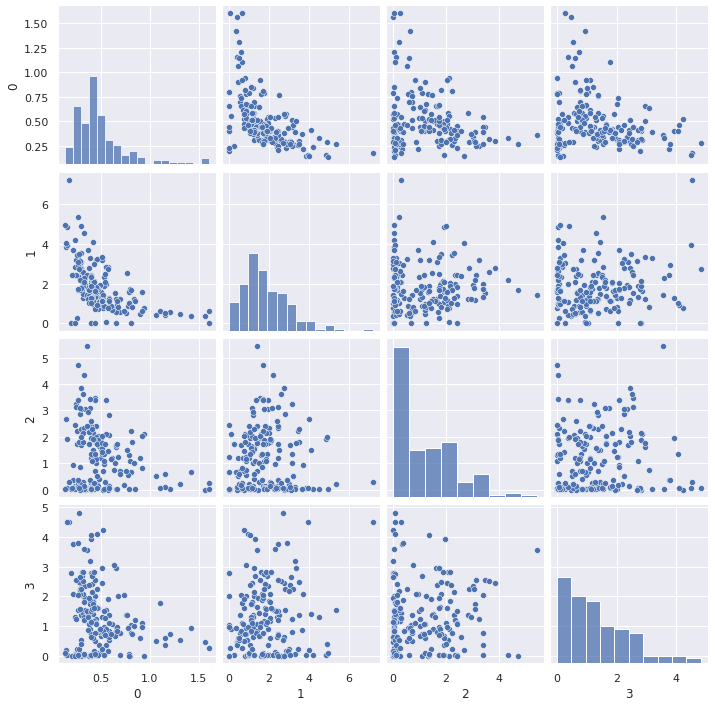

In [57]:
sns.pairplot(pd.DataFrame(samples[:, 0:4]))

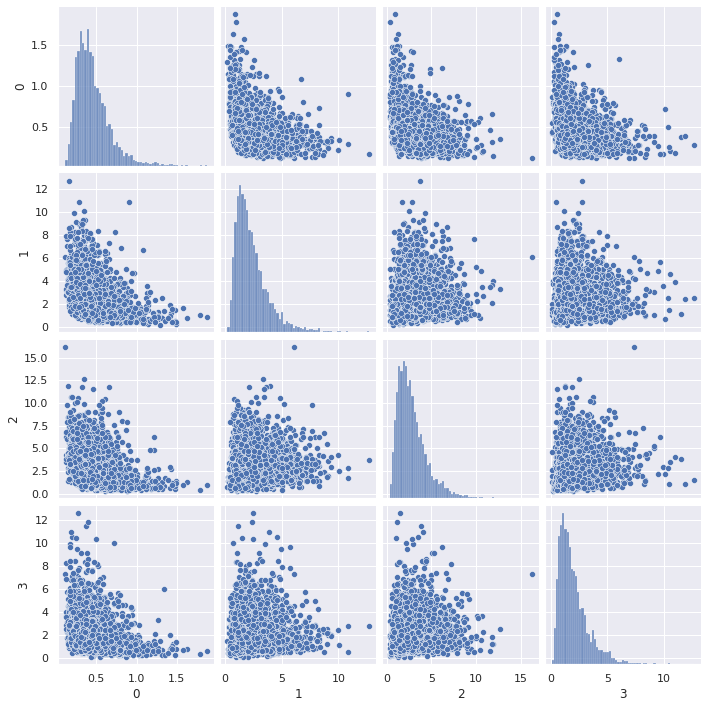

In [25]:
sns.pairplot(pd.DataFrame(truth_x[:, 0:4]))

     labels     $x_0$     $x_1$     $x_2$
0         q  0.572095  1.586241 -0.696956
1         q  0.344287  0.254319 -0.917772
2         q  0.401333  0.116806 -2.494058
3         q  0.164820  0.419251  0.410184
4         q  0.119810  0.628131  0.665926
...     ...       ...       ...       ...
5995      T  0.414095  0.017307 -0.479650
5996      T  0.601444  0.003669 -1.063157
5997      T  0.682545  0.013140 -0.857163
5998      T  0.304233  1.527951 -1.242758
5999      T  0.282785  0.113599 -1.359838

[6000 rows x 4 columns]


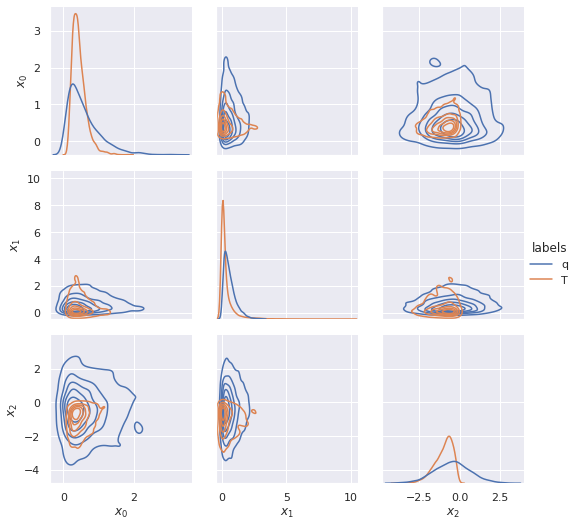

In [49]:
q = q_models['DLA_51']

qx = q.sample(2000)
qx = qx.detach().numpy()

qx[:, 0:26] = qx[:, 0:26]


idx = np.array([0, 24, 30])
sns_pairplot(qx[:, idx], np.ones(len(qx)), truth_samples=truth_x[:, idx], levels=6)

     labels     $x_0$     $x_1$     $x_2$
0         q  0.572095  1.586241 -0.696956
1         q  0.344287  0.254319 -0.917772
2         q  0.401333  0.116806 -2.494058
3         q  0.164820  0.419251  0.410184
4         q  0.119810  0.628131  0.665926
...     ...       ...       ...       ...
2179      T  0.333232  0.291337  1.184343
2180      T  0.206435  0.182680 -1.575167
2181      T  0.194699  0.056607 -0.586169
2182      T  0.164992  1.025170 -0.183963
2183      T  0.280479  0.738883 -0.631766

[2184 rows x 4 columns]


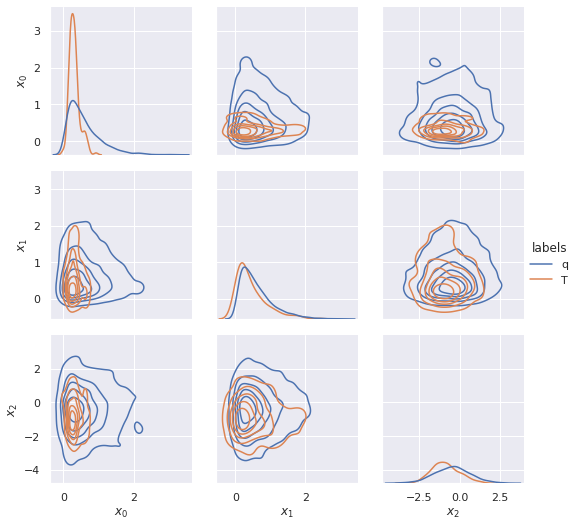

In [50]:
sns_pairplot(qx[:, idx], np.ones(len(qx)), samples[:, idx], levels=6)

# 1d Marginals ...

In [41]:
print(jnp.shape(truth_x))
print(jnp.shape(samples))

(4000, 51)
(102, 51)


/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.4 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

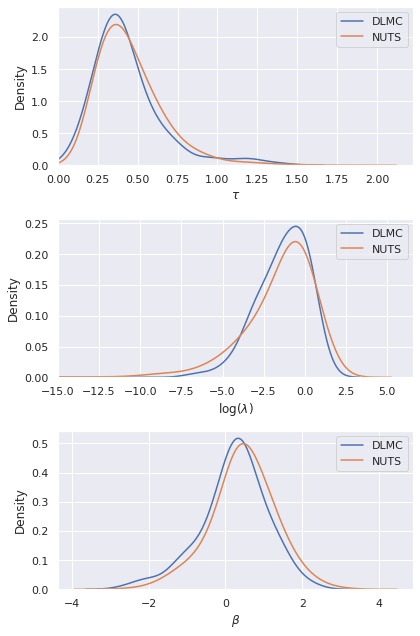

In [28]:
mh_samples = trace['mh_samples'][0]
dla_key = 'DLA_90'

samples = mh_samples[dla_key]
#samples = samples.at[:, 0:26].set(np.exp(samples[:, 0:26]))

np.savetxt(f'./dla_figs/german_credit_{dla_key}.txt', samples)

stan = np.loadtxt('./fiducial_samples/german_posterior_samples_stan.txt')

sub_idx = np.random.choice(np.arange(len(truth_x)), len(samples), replace=False)

sns.set_theme()
fig = plt.figure(figsize=(2 * 2 * 1.5, 2 * 1.5 * 3))
plt.subplot(3, 1, 1)
sns.kdeplot(samples[:, 0], label='DLMC', clip=(0, float('inf')), bw=0.4)
sns.kdeplot(truth_x[:, 0], label='NUTS', clip=(0, float('inf')), bw=0.4)
plt.xlabel(r'$\tau$')
plt.xlim(0)
plt.legend(loc='upper right')
plt.subplot(3, 1, 2)
sns.kdeplot(np.log(samples[:, 10]), label='DLMC', bw=0.4)
sns.kdeplot(np.log(truth_x[:, 10]), label='NUTS', bw=0.4)
plt.xlabel(r'$\log(\lambda)$')
plt.xlim(-15)
#plt.xlim(0, 3)
plt.legend(loc='upper right')
plt.subplot(3, 1, 3)
sns.kdeplot(samples[:, 44], label='DLMC', bw=0.4)
sns.kdeplot(truth_x[:, 44], label='NUTS', bw=0.4)
plt.xlabel(r'$\beta$')
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig(f'./dla_figs/paper/german_credit_{dla_key}')

In [73]:
dlmc_mu = np.mean(samples, axis=0)
pymc_mu = np.mean(truth_x, axis=0)
print(f'dlmc_mu = {dlmc_mu}')
print(f'pymc_mu = {pymc_mu}')

dlmc_var = np.var(samples, axis=0)
pymc_var = np.var(truth_x, axis=0)
print(f'dlmc_var = {dlmc_var}')
print(f'pymc_var = {pymc_var}')

dlmc_mu = [ 0.49121326  1.8135718   1.1574888   1.3159611   1.039627    1.0352038
  0.7168682   0.5638721   0.5463525   0.8667178   0.6472456   0.8251841
  0.7908612   0.49157003  0.5964525   0.57218355  0.8605766   0.808814
  0.7427436   0.67709315  0.6821215   0.7489569   0.8190338   0.70616186
  0.5746244   0.75157404 -1.2327      0.84753525 -0.8956652   0.4903272
 -0.89982367 -0.55717224 -0.22006254  0.07839137  0.578249   -0.43841943
 -0.5333762   0.05697456  0.0470625  -0.26112854 -0.32337818  0.63409156
 -0.89727235  0.43830562  0.2754049   0.13782771 -0.45230877 -0.29687384
 -0.01400869  0.00542756  0.34117478]
pymc_mu = [ 0.45228521  2.34629122  2.82163016  2.0431403   0.67127468  1.56592618
  0.82718602  0.74276446  0.37003276  1.11030719  0.6924825   0.78956014
  0.63806351  0.34216532  0.33932871  0.948141    1.10651309  1.68183317
  0.93162838  0.8204746   0.63236291  0.52658638  0.69985543  0.3566122
  0.32737547  1.50235806 -1.14708649  1.26474067 -1.09342058  0.29590989

/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.5 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/seaborn/distributions.py:1657: FutureWarning: The `bw` parameter is deprecated in favor of `bw_method` and `bw_adjust`. Using 0.3 for `bw_method`, but please see the docs for the new parameters and update your code.
  warnings.warn(msg, FutureWarning)
/home/richard/anaconda3/envs/jax/lib/python3.9/site-packages/

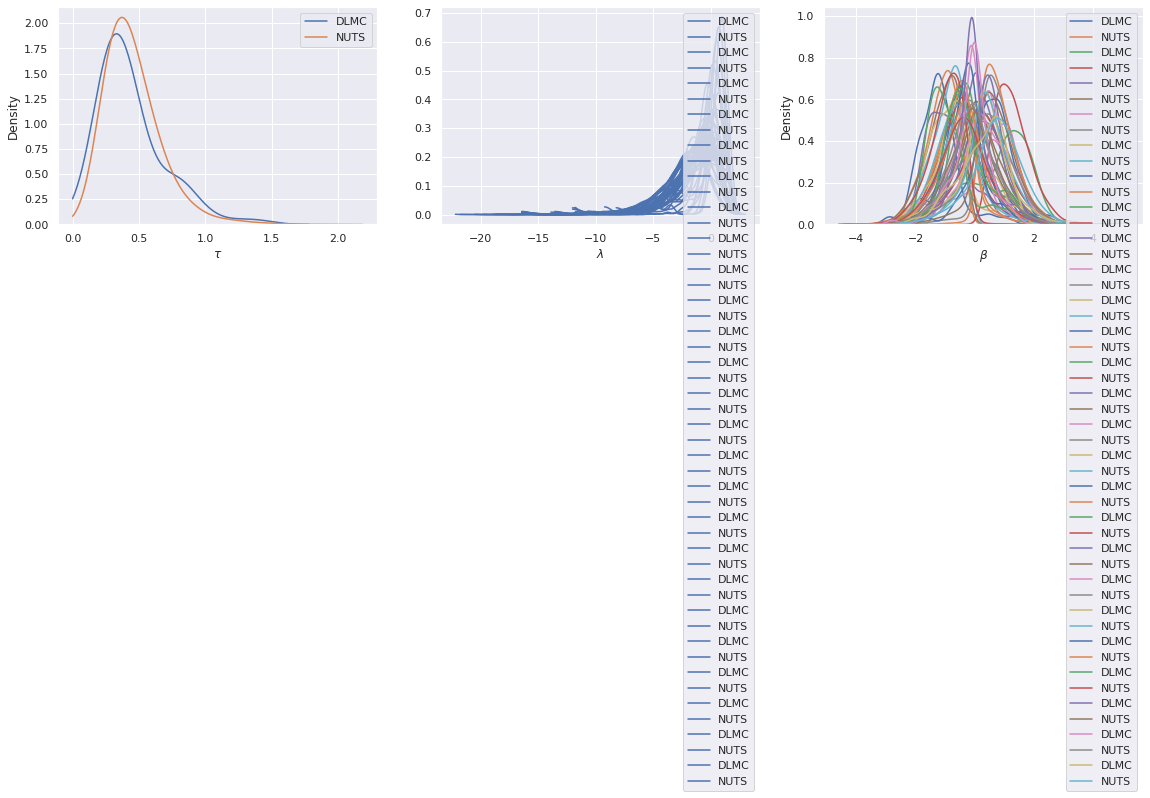

In [61]:
sns.set_theme()
fig = plt.figure(figsize=(3.24 * 3 * 2, 2 * 2))
plt.subplot(1, 3, 1)
sns.kdeplot(samples[:, 0], label='DLMC', clip=(0, float('inf')), bw=0.5)
sns.kdeplot(truth_x[:, 0], label='NUTS', clip=(0, float('inf')), bw=0.5)
plt.xlabel(r'$\tau$')
#plt.xlim(0)
plt.legend(loc='upper right')
plt.subplot(1, 3, 2)
az.plot_trace(az.convert_to_dataset(np.log(samples[:, 1:26].T)), label='DLMC')
az.plot_trace(az.convert_to_dataset(np.log(truth_x[:, 1:26].T)), label='NUTS')
#sns.kdeplot(samples[:, i + 1], label='DLMC', clip=(0, float('inf')), bw=0.6)
#sns.kdeplot(truth_x[:, i + 1], label='NUTS', clip=(0, float('inf')), bw=0.6)
plt.xlabel(r'$\lambda$')
#plt.xlim(0, 3)
plt.legend(loc='upper right')
plt.subplot(1, 3, 3)
for i in range (d):
    sns.kdeplot(samples[:, i + d + 1], label='DLMC', bw=0.3)
    sns.kdeplot(truth_x[:, i + d + 1], label='NUTS', bw=0.3)
plt.xlabel(r'$\beta$')
plt.legend(loc='upper right')
plt.tight_layout()

array([[<AxesSubplot:title={'center':'x'}>,
        <AxesSubplot:title={'center':'x'}>]], dtype=object)

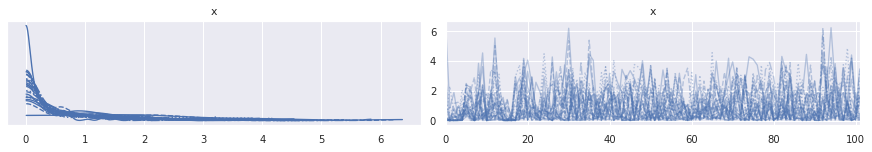

In [55]:
data_lam = az.convert_to_dataset(np.asarray(samples[:, 1:26].T))
az.plot_trace(data_lam)

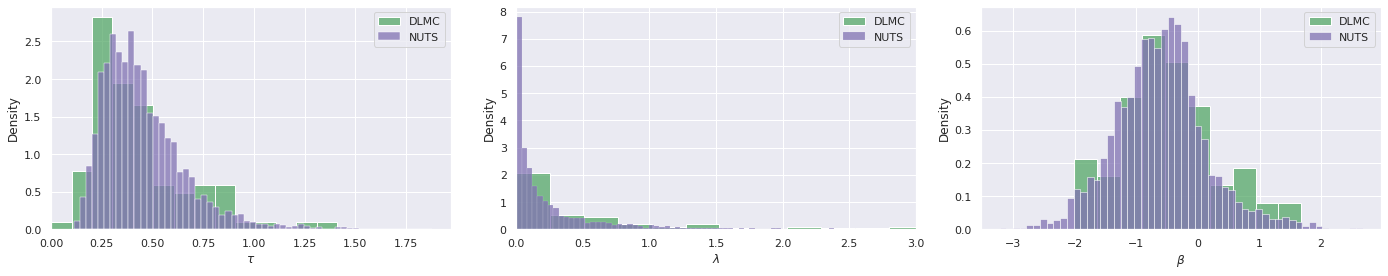

In [51]:
sns.set_theme()
fig = plt.figure(figsize=(3.24 * 3 * 2, 2 * 2))
plt.subplot(1, 3, 1)
sns.histplot(samples[:, 0], label='DLMC', stat='density', color='g')
sns.histplot(truth_x[:, 0], label='NUTS', stat='density', color='m')
plt.xlabel(r'$\tau$')
plt.xlim(0)
plt.legend(loc='upper right')
plt.subplot(1, 3, 2)
sns.histplot(samples[:, 24], label='DLMC', stat='density', color='g')
sns.histplot(truth_x[:, 24], label='NUTS', stat='density', color='m')
plt.xlabel(r'$\lambda$')
plt.xlim(0, 3)
plt.legend(loc='upper right')
plt.subplot(1, 3, 3)
sns.histplot(samples[:, 40], label='DLMC', stat='density', color='g')
sns.histplot(truth_x[:, 40], label='NUTS', stat='density', color='m')
plt.xlabel(r'$\beta$')
plt.legend(loc='upper right')
plt.tight_layout()

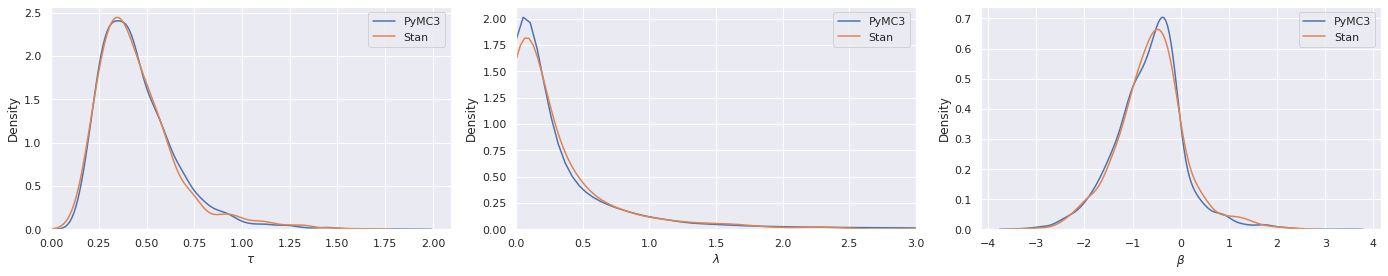

In [22]:
sns.set_theme()
fig = plt.figure(figsize=(3.24 * 3 * 2, 2 * 2))
plt.subplot(1, 3, 1)
sns.kdeplot(truth_x[:, 0], label='PyMC3', clip=(0, float('inf')))
sns.kdeplot(stan[:, 50], label='Stan', clip=(0, float('inf')))
plt.xlabel(r'$\tau$')
plt.xlim(0)
plt.legend(loc='upper right')
plt.subplot(1, 3, 2)
sns.kdeplot(truth_x[:, 24], label='PyMC3', clip=(0, float('inf')))
sns.kdeplot(stan[:, 38], label='Stan', clip=(0, float('inf')))
plt.xlabel(r'$\lambda$')
plt.xlim(0, 3)
plt.legend(loc='upper right')
plt.subplot(1, 3, 3)
sns.kdeplot(truth_x[:, 31], label='PyMC3')
sns.kdeplot(stan[:, 5], label='Stan')
plt.xlabel(r'$\beta$')
plt.legend(loc='upper right')
plt.tight_layout()

In [50]:
def marginal_plots(tau_samples, lam_samples, beta_samples, tau_truth, lam_truth, beta_truth, 
                   q_label='DLMC', truth_label='NUTS', out_name=None):
    
    q_samples = np.asarray(q_samples)
    q_weights = np.asarray(q_weights)
    if truth_samples is not None:
        truth_samples = np.asarray(truth_samples)
        labels = np.empty(len(q_samples) + len(truth_samples), dtype=str)
        labels[:len(q_samples)] = q_label
        labels[len(q_samples):] = truth_label
        x_samples = np.concatenate([q_samples, truth_samples])
        weights = np.concatenate([q_weights, np.ones(len(truth_samples))])
    else:
        labels = np.empty(len(q_samples), dtype=str)
        labels[:] = q_label
        x_samples = q_samples
        weights = q_weights
    
    
    d = {}
    d['labels'] = labels
    for i in range(x_samples.shape[1]):
        d[f'$x_{i}$'] = x_samples[:, i]
        
    df = pd.DataFrame(d)
    print(df)
    
    sns.set_theme()
    g = sns.PairGrid(df, hue='labels', palette='deep')
    g.map_diag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.map_offdiag(sns.kdeplot, weights=weights, common_norm=False, levels=levels)
    g.add_legend()
    if out_name is not None:
        g.savefig(out_name)

7.969900616444647e-05
-2.338529586791992


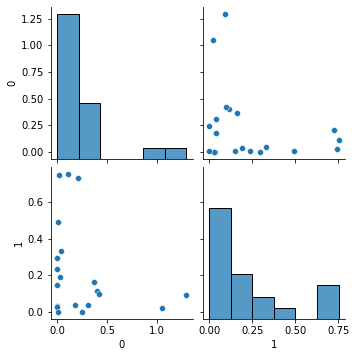

In [10]:
p = np.loadtxt('/home/richard/nfmc_jax_tests/fiducial_samples/prior_dla_samples.txt')
mh = np.loadtxt('./fiducial_samples/latent_dla_mh_samples_check.txt')

print(np.amin(p[:, 0:1]))
print(np.amin(mh[:, 0:1]))

sns.pairplot(pd.DataFrame(p[:, 0:2]))

In [29]:
prop = np.loadtxt('./fiducial_samples/latent_prop_check.txt')
print(np.amin(prop[:, 0:26]))

print(jnp.where(prop[:, 7] < 0))

-6.185309757711366e-06
(DeviceArray([6], dtype=int32),)


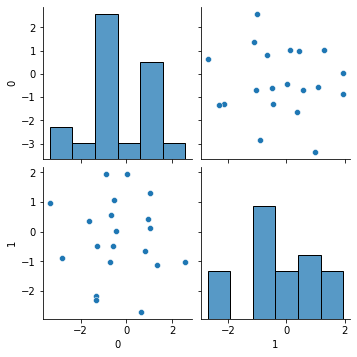

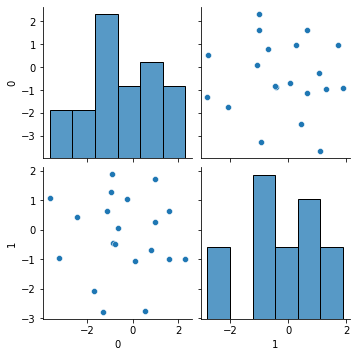

In [14]:
old_z = np.loadtxt('./fiducial_samples/latent_z_old.txt')
prop_z = np.loadtxt('./fiducial_samples/latent_z_prop_check.txt')

sns.pairplot(pd.DataFrame(old_z[:, 0:2]))
sns.pairplot(pd.DataFrame(prop_z[:, 0:2]))

In [11]:
import pickle
f = open('./qfit_initial.obj', 'rb')
q = pickle.load(f)
f.close()

In [12]:
q

In [34]:
q.logq(q.inverse(torch.tensor(np.asarray(prop_z[2, :]), dtype=torch.float32)))

tensor([-25.3510])

In [35]:
logp = jax.vmap(lambda x: log_prior(x))(prop)

In [36]:
logp

DeviceArray([-31.20182 , -21.683876, -21.14117 , -22.339197, -13.540211,
             -27.489372,       -inf,       -inf, -38.43962 , -33.43325 ,
             -30.829414,  -9.907322, -28.787388, -38.03463 , -19.716305,
             -28.898893, -30.91468 , -19.14558 ,       -inf, -28.853788],            dtype=float32)

# Other runs

In [9]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed
init_logq = None

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0.98, 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = None
trainable_qw = False # Just leave this for now.
sgd_steps = 10
gamma = 0
knots_trainable = None
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = False
Whiten_with_weights = False
iteration = None
NERCOME = False
t_ess = 0.5
MSWD_max_iter = None
Whiten_reg = 0.98

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.0
frac_validate = 0.2
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 0.5
reg2 = 0.5
latent_mcmc = 'LIMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True
fixed_beta_updates = 'LIMH'
nf_iter = 25
slice_iterations = 10

dla_step_size = 1.0
num_extra_dla_samples = 164
grad_norm_thresh = 0.3
max_dla_line_steps = 5
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.2
accelerate_dla = False
grad_free_dla = False
dla_beta_thresh = 0.3
latent_dla = True
rel_fish_tol = 1e-2
abs_fish_tol = 1e-3
maxknot = False

max_dla_iter = 100

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 200

mala_step_size = 1.0
num_mala = 0
tune_mala = 50

cull_lowp_tol = 1e-2

In [ ]:
trace2 = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_prior,
                             prior_rvs_func=prior_rvs,
                             init_samples=prior_init,
                             log_like_args=log_like_args,
                             log_prior_args=log_prior_args,
                             init_logq=None,
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             frac_validate=frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla,
                             dla_beta_thresh=dla_beta_thresh,
                             latent_dla=latent_dla,
                             rel_fish_tol=rel_fish_tol,
                             abs_fish_tol=abs_fish_tol,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             cull_lowp_tol=cull_lowp_tol,
                             maxknot=maxknot,
                             MSWD_max_iter=MSWD_max_iter,
                             Whiten_reg=Whiten_reg)

Inference mode is DLA. Maximum beta is set to 1.
bounds_sinf = [[0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [0, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None], [None, None]]
prop_likelihood_logp = [-990.91785 -817.3309  -952.46423 -706.5893  -922.35187 -767.1121
 -997.9     -584.046   -842.8877  -823.199   -609.14246 -653.30396
 -688.84955 -779.7335  -792.318   -856.1808  -692.06195 -798.8527
 -640.26385 -705.2555 ]
prop_prior_logp = [      -inf       -inf       -inf   

prop_likelihood_logp = [ -693.1458   -663.65784  -679.4295  -1302.3169   -692.7802 ]
prop_prior_logp = [-inf -inf -inf -inf -inf]
prop_logp = [-inf -inf -inf -inf -inf]
increased_logL = []
decreased_logL = [0 1 2 3 4]
nan_inf = [0 1 2 3 4]
prop_likelihood_logp = [ -693.15594  -663.71545  -679.4677  -1302.5719   -692.784  ]
prop_prior_logp = [-19.052414       -inf       -inf       -inf       -inf]
prop_logp = [-712.2084      -inf      -inf      -inf      -inf]
increased_logL = [0]
decreased_logL = [1 2 3 4]
nan_inf = [1 2 3 4]
prop_likelihood_logp = [ -663.7444  -679.4867 -1302.6996  -692.7859]
prop_prior_logp = [      -inf       -inf -17.031317 -14.989872]
prop_logp = [       -inf        -inf -1319.731    -707.77576]
increased_logL = [2 3]
decreased_logL = [0 1]
nan_inf = [0 1]
prop_likelihood_logp = [-663.75885 -679.4962 ]
prop_prior_logp = [      -inf -12.863464]
prop_logp = [     -inf -692.3597]
increased_logL = [1]
decreased_logL = [0]
nan_inf = [0]
prop_likelihood_logp = [-663.766

Time for DLA MH adjustment = 2.362243031999924
<norm> = 41.834617614746094
max(norm) = 127.3642578125
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0217391304347827
Time for latent space DLA = 9.176045466999994
Stage 11, Sample Mean: 0.09616558998823166
Stage 11, Sample Variance: 0.8450065851211548
Current logZ estimate = -529.580810546875
DLA stage 11, Latent Fisher Divergence: 1540.9189453125
Primary DLA stage 11, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.006118470802903175
Acceptance rate for MH adjustment: 0.04891304347826087
Time for DLA MH adjustment = 2.150723027999902
<norm> = 35.925865173339844
max(norm) = 146.6967010498047
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.1032608695652173
Time for latent space DLA = 8.91863859099999
Stage 12, Sample Mean: 0.09239506721496582
Stage 12, Sample Variance: 0.8321531414985657
Current logZ estimate = -5

Current logZ estimate = -483.5981140136719
DLA stage 24, Latent Fisher Divergence: 676.7720336914062
Primary DLA stage 24, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.04651036113500595
Acceptance rate for MH adjustment: 0.010869565217391304
Time for DLA MH adjustment = 2.06997093699988
<norm> = 24.83645248413086
max(norm) = 61.158851623535156
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.016304347826087
Time for latent space DLA = 8.251522628999965
Stage 25, Sample Mean: 0.08730572462081909
Stage 25, Sample Variance: 0.7869635820388794
Current logZ estimate = -487.0815734863281
DLA stage 25, Latent Fisher Divergence: 606.5006103515625
Primary DLA stage 25, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.056876908987760544
Acceptance rate for MH adjustment: 0.005434782608695652
Time for DLA MH adjustment = 2.1991295380000793
<norm> = 23.348169326782227
max(norm) = 82.11922454833984
Number of particles that did not get updated by DLA line sear

Time for latent space DLA = 10.066111248999732
Stage 38, Sample Mean: 0.10002333670854568
Stage 38, Sample Variance: 0.7593534588813782
Current logZ estimate = -461.3216552734375
DLA stage 38, Latent Fisher Divergence: 755.6809692382812
Primary DLA stage 38, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.07512251287698746
Acceptance rate for MH adjustment: 0.010869565217391304
Time for DLA MH adjustment = 2.133697427000243
<norm> = 23.756698608398438
max(norm) = 99.1541976928711
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0108695652173914
Time for latent space DLA = 8.327134221000051
Stage 39, Sample Mean: 0.10009296983480453
Stage 39, Sample Variance: 0.7578186988830566
Current logZ estimate = -463.07427978515625
DLA stage 39, Latent Fisher Divergence: 1384.8533935546875
Primary DLA stage 39, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.06493458896875381
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.118051071000081

Time for latent space DLA = 10.002983893999954
Stage 52, Sample Mean: 0.1149362102150917
Stage 52, Sample Variance: 0.727702260017395
Current logZ estimate = -454.173095703125
DLA stage 52, Latent Fisher Divergence: 447.4089660644531
Primary DLA stage 52, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.06795136630535126
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.430589241999769
<norm> = 20.033964157104492
max(norm) = 54.17295837402344
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0
Time for latent space DLA = 9.322286136000002
Stage 53, Sample Mean: 0.11592597514390945
Stage 53, Sample Variance: 0.7257970571517944
Current logZ estimate = -451.280029296875
DLA stage 53, Latent Fisher Divergence: 3583.58935546875
Primary DLA stage 53, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.07951898872852325
Acceptance rate for MH adjustment: 0.016304347826086956
Time for DLA MH adjustment = 2.186970052000106
<norm> = 25.42318534

Time for latent space DLA = 11.187425442999938
Stage 66, Sample Mean: 0.12676207721233368
Stage 66, Sample Variance: 0.6998432278633118
Current logZ estimate = -449.37420654296875
DLA stage 66, Latent Fisher Divergence: 364.177734375
Primary DLA stage 66, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.06505908817052841
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.545895183000084
<norm> = 18.000446319580078
max(norm) = 47.67723083496094
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0
Time for latent space DLA = 9.337963923999723
Stage 67, Sample Mean: 0.12765145301818848
Stage 67, Sample Variance: 0.6988458037376404
Current logZ estimate = -445.4267883300781
DLA stage 67, Latent Fisher Divergence: 711.1146850585938
Primary DLA stage 67, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.08557549118995667
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.5104189480002788
<norm> = 18.03107261657715
max(nor

Time for latent space DLA = 8.78602595800021
Stage 80, Sample Mean: 0.1380447894334793
Stage 80, Sample Variance: 0.6864458918571472
Current logZ estimate = -442.5467224121094
DLA stage 80, Latent Fisher Divergence: 448.2427673339844
Primary DLA stage 80, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.07371745258569717
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.080574157999763
<norm> = 20.564895629882812
max(norm) = 43.550254821777344
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0
Time for latent space DLA = 8.063340755999889
Stage 81, Sample Mean: 0.13875655829906464
Stage 81, Sample Variance: 0.6859884858131409
Current logZ estimate = -441.0666198730469
DLA stage 81, Latent Fisher Divergence: 575.04443359375
Primary DLA stage 81, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.07822626829147339
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.9407146620005733
<norm> = 16.47461700439453
max(norm

Current logZ estimate = -443.2008056640625
DLA stage 94, Latent Fisher Divergence: 326.0296325683594
Primary DLA stage 94, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.0708165317773819
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 1.9782725270006267
<norm> = 15.839098930358887
max(norm) = 59.916446685791016
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA line search iterations: 1.0108695652173914
Time for latent space DLA = 8.450284890999683
Stage 95, Sample Mean: 0.14929358661174774
Stage 95, Sample Variance: 0.6777675747871399
Current logZ estimate = -447.30108642578125
DLA stage 95, Latent Fisher Divergence: 498.94085693359375
Primary DLA stage 95, abs[(Z(i+1) - Z(i)) / Z(i)] = 0.0619594007730484
Acceptance rate for MH adjustment: 0.0
Time for DLA MH adjustment = 2.110054666999531
<norm> = 21.674345016479492
max(norm) = 41.61156463623047
Number of particles that did not get updated by DLA line search: 0
Mean number of latent DLA 

In [ ]:
'''
General parameters
------------------
In addition to the log-likelihood and prior functions defined above that you'll pass, we have:

1. log_like_args: Any additional arguments to be passed to the log-likelihood function as a tuple object.
2. log_prior_args: As above but for the prior. Not necessary here, but I've included arguments for illustration.
3. inference_mode: Either 'optimization' or 'sampling'. You'll want 'sampling'.
4. vmap: If True we evaluate the log-likelihood and prior functions using a vectorizing map (i.e. jax.vmap). 
   If False we parallelise the computation over available cores. The parallelisation has been tested on NERSC, 
   but I've pretty much exclusively been using vmap (you may want to parallelise if you have some very expensive 
   likelihoods).
5. parallel_backend: If using parallel evaluations, choose the parallel backend. Can be set to Pool, Client or
   MapReduce. Will use multiprocess, dask or sharedmem respectively. If left as None, will use multiprocess.
6. bounds: Any hard parameter bounds to pass to SINF/SNF. Passed as array([lower_bounds, upper_bounds]). None
   if no hard bounds.
7. k_trunc: Clipping parameter for importance weights. IW clipped at <IW>*N^k_trunc. Note, not currently used
   with SMC-type sampling.
8. random_seed: Random seed for inference.
'''
log_like_args = ()
log_prior_args = () 
inference_mode = 'DLA'
vmap = True
parallel_backend = None
bounds = np.array([lower, upper])
k_trunc = 0.5
random_seed = seed
init_logq = None

'''
SINF/SNF parameters
---------------
Key SINF/SNF parameters. See GIS.py, SINF.py and optimize.py for code.

1. alpha_w: Regularisation parameters for weighted q SINF fits. Passed as a tuple of two values between 0 and 1. 
   Closer to 1 will give more regularisation. If set to None, SINF uses cross-validation to choose a value.
2. NBfirstlayer: Whether to use a Naive Bayes first layer in SINF.
3. verbose: Whether you want verbose output from SINF.
4. interp_nbin: Number of spline knots for rational quadratic splines in SINF. 
5. trainable_qw: Whether to run SNF after SINF. This was relevant when SINF and SNF were contained in the same
   method. There are separate methods now, and I'm using this so I can more easily change things. You should
   probably leave this as False for now. It won't break anything if you set it as True. Just means you'll run 
   SNF one more time than you think.
6. sgd_steps: Number of stochastic gradient descent steps to take for SNF training.
7. gamma: Parameter in loss function 1 (log E(q^(-gamma)*(p - Zq)^2)). 
8. knots_trainable: Only relevant if trainable_qw is True, in which case this overwrites interp_nbin.
9. optimize_directions: Whether we optimize directions in SNF.
10. logp_cut: logp threshold to be applied during SNF training. Currently I don't impose a cut.
11. edge_bins: Number of spline knots at the boundary.
12. Whiten: Whether to include a whitening layer for SINF.
13. iteration: Maximum number of SINF layers.
14. NERCOME: Whether to use the NERCOME algorithm for SINF.
'''
#sinf parameters
alpha_w = (0.98, 0.98)
NBfirstlayer = True
verbose = False
interp_nbin = None
trainable_qw = False # Just leave this for now.
sgd_steps = 10
gamma = 0
knots_trainable = None
optimize_directions = None
logp_cut = None
edge_bins = 0
Whiten = True
Whiten_with_weights = True
iteration = None
NERCOME = False
t_ess = 0.5
MSWD_max_iter = None
Whiten_reg = 0.98

'''
SMC parameters
--------------
Parameters used for SMC and MH exploration strategies.

1. nfmc_frac_validate: Fraction of samples used in validation for SINF/SNF.
2. min_delta_beta_init: Minimum relative change in beta at start.
3. min_delta_beta_final: Minimum relative change in beta at end. delta_beta decays to this between start and end.
4. snf_loss: Specify the SNF loss function. (0) E(q^(-gamma)*(p - Zq)^2), (1) log E(q^(-gamma)*(p - Zq)^2),
   (2) sum((logp-logq-logZ)^2), (3) -E(logq), (4) log(E((q/q_uw)(p/q - Z)^2)).
5. nfmc_snf_only: Whether to only use trainable SNF updates to q after the first q fit.
6. fixed_beta_schedule: Can specify a fixed beta schedule as a list of beta values.
7. vanilla_smc: Whether to use the SMC+MH exploration strategy. This is currently the focus for sampling.
   Old option was to intialise using NFO optimization.
8. reg: SNF regularisation parameter.
9. reg1: SNF regularisation parameter.
10. mh_mode: Specify 'IMH' for independent MH exploration, 'CMH' for latent space MH, 'both' for using both.
    CMH is still being tested so stick with 'IMH' for now.
11. imh_target_acc_rate: Target acceptance fraction for original samples in IMH.
12. max_imh_steps: Maximum number of IMH iterations at a given temperature level.
13. cmh_target_acc_rate: Target acceptance rate for CMH exploration.
14. max_cmh_steps: Maximum number of steps in a CMH chain.
15. cmh_p_acc_rate: Parameter used for tuning number of CMH steps. Between 0 and 1. Closer to 1 results in more
    steps.
16. sinf_resampled: Whether to fit SINF using re-sampled samples and uniform weight.
'''
nfmc_frac_validate = 0.0
frac_validate = 0.2
min_delta_beta_init = 0.01
min_delta_beta_final = 0.01
snf_loss = 3
nfmc_snf_only = False
fixed_beta_schedule = None
vanilla_smc = True
reg = 0.0
reg1 = 0.5
reg2 = 0.5
latent_mcmc = 'LIMH'
imh_target_acc_rate = 0.5
max_imh_steps = 25
cmh_target_acc_rate = 0.234
max_cmh_steps = 25
cmh_p_acc_rate = 0.85
sinf_resampled = True
fixed_beta_updates = 'LIMH'
nf_iter = 25
slice_iterations = 10

dla_step_size = 1.0
num_extra_dla_samples = 164
grad_norm_thresh = 0.3
max_dla_line_steps = 5
log_like_grad = log_like_grad
log_prior_grad = log_prior_grad
eps_z = 0.2
accelerate_dla = False
grad_free_dla = False
dla_beta_thresh = 0.3
latent_dla = True
rel_fish_tol = 1e-2
abs_fish_tol = 1e-3
maxknot = False

max_dla_iter = 100

flow_type = 'SINF'
maf_layers = 10
maf_hidden = 5
maf_activation = torch.sigmoid
dropout_prob = 0.2
maf_epochs = 200

mala_step_size = 1.0
num_mala = 0
tune_mala = 50

cull_lowp_tol = 1e-2

In [ ]:
trace3 = nfmc_jax.infer_nfomc(log_like_func=log_like, 
                             log_prior_func=log_prior,
                             prior_rvs_func=prior_rvs,
                             init_samples=prior_init,
                             log_like_args=log_like_args,
                             log_prior_args=log_prior_args,
                             init_logq=None,
                             inference_mode=inference_mode, 
                             vmap=vmap, 
                             parallel_backend=parallel_backend, 
                             bounds=bounds,
                             k_trunc=k_trunc,
                             #sinf parameters
                             alpha_w=alpha_w,
                             NBfirstlayer=NBfirstlayer, 
                             verbose=verbose,
                             interp_nbin=interp_nbin,
                             iteration=iteration,
                             trainable_qw=trainable_qw,
                             sgd_steps=sgd_steps,
                             gamma=gamma,
                             knots_trainable=knots_trainable,
                             optimize_directions=optimize_directions,
                             logp_cut=logp_cut,
                             random_seed=seed,
                             edge_bins=edge_bins,
                             Whiten=Whiten,
                             Whiten_with_weights=Whiten_with_weights,
                             #SMC parameters
                             nfmc_frac_validate=nfmc_frac_validate,
                             frac_validate=frac_validate,
                             min_delta_beta_init=min_delta_beta_init,
                             min_delta_beta_final=min_delta_beta_final,
                             snf_loss=snf_loss,
                             nfmc_snf_only=nfmc_snf_only,
                             fixed_beta_schedule=fixed_beta_schedule,
                             vanilla_smc=vanilla_smc,
                             reg=reg,
                             reg1=reg1,
                             reg2=reg2,
                             latent_mcmc=latent_mcmc,
                             imh_target_acc_rate=imh_target_acc_rate,
                             max_imh_steps=max_imh_steps,
                             cmh_target_acc_rate=cmh_target_acc_rate,
                             max_cmh_steps=max_cmh_steps, 
                             cmh_p_acc_rate=cmh_p_acc_rate,
                             t_ess=t_ess,
                             NERCOME=NERCOME,
                             fixed_beta_updates=fixed_beta_updates,
                             nf_iter=nf_iter,
                             dla_step_size=dla_step_size,
                             num_extra_dla_samples=num_extra_dla_samples,
                             grad_norm_thresh=grad_norm_thresh,
                             log_like_grad=log_like_grad,
                             log_prior_grad=log_prior_grad,
                             max_dla_line_steps=max_dla_line_steps,
                             eps_z=eps_z,
                             accelerate_dla=accelerate_dla,
                             grad_free_dla=grad_free_dla,
                             dla_beta_thresh=dla_beta_thresh,
                             latent_dla=latent_dla,
                             rel_fish_tol=rel_fish_tol,
                             abs_fish_tol=abs_fish_tol,
                             max_dla_iter=max_dla_iter,
                             flow_type=flow_type,
                             maf_layers=maf_layers,
                             maf_hidden=maf_hidden,
                             maf_activation=maf_activation,
                             dropout_prob=dropout_prob,
                             maf_epochs=maf_epochs,
                             mala_step_size=mala_step_size,
                             num_mala=num_mala,
                             tune_mala=tune_mala,
                             cull_lowp_tol=cull_lowp_tol,
                             maxknot=maxknot,
                             MSWD_max_iter=MSWD_max_iter,
                             Whiten_reg=Whiten_reg)